# US Wildfire classification

Problem statement:
Find cause of fire given below information
1. Size of fire
2. date
3. location

##### Summary:
1. Multiple classifiers were attempted
    - DecisionTree
    - RandomForest
    - AdaBoost
    - BaggingClassfier and
    - MLPClassifier
2. feature processing was performed
    - Date info to year, quarter, month, doy to use in classifier
    - quarter, month, doy were processes to get cyclical features to capture seasonal relations
    - categorical features, fire_size_class were transformed to numerical values 
    - For Neural networks lat, lon and fire_size were standardized 
3. Data seems to be highly skewed just 2 fire causes covering 40% of cases. large fires are really small number and are further divided into different causes spread over years
4. BaggingClassfier performed best in this experiment with 60% accuracy when tested over 20% dataset. 
5. RandomForest and BaggingClassifier failed to work on full dataset and kept on failing with memory related errors.

##### Open questions:
1. Can this performance be improved further?
2. How to add information about trend information to features?


## Initial import

In [1]:
from src import dbutils
import pandas as pd
import sqlalchemy as sa
import os
import matplotlib.pyplot as plt
import time
import seaborn as sns


### Declare variable

In [2]:
SQLITE_FILE = "sqlite:///app/db/wildfires_us.sqlite"

# table name in SQLite file
TBL_NAME = 'Fires'

stmt = f'''select discovery_date, fire_size, fire_size_class,
            latitude as lat, longitude as lon, fips_code, 
            stat_cause_code, stat_cause_descr from {TBL_NAME} '''


## Read Data

In [3]:
df = dbutils.read_sqlite_data(stmt, SQLITE_FILE)
# columns to lower
df.columns = df.columns.str.lower()

# Align lat long to .1 degree resolution
df = df.round({'lat':1,
                'lon':1})


### Add additional feature from date information

In [4]:


# Add some extra columns/features for date 
df['discovery_date'] = pd.to_datetime(df['discovery_date'],origin='julian', unit='D')
df['year'] = df['discovery_date'].dt.year
df['month'] = df['discovery_date'].dt.month
df['doy'] = df['discovery_date'].dt.dayofyear
df['quarter'] = df['discovery_date'].dt.quarter
df.head()

,discovery_date,fire_size,fire_size_class,lat,lon,fips_code,stat_cause_code,stat_cause_descr,year,month,doy,quarter
0,2005-02-02,0.10,A,40.0,-121.0,063,9.0,Miscellaneous,2005,2,33,1
1,2004-05-12,0.25,A,38.9,-120.4,061,1.0,Lightning,2004,5,133,2
2,2004-05-31,0.10,A,39.0,-120.7,017,5.0,Debris Burning,2004,5,152,2
3,2004-06-28,0.10,A,38.6,-119.9,003,1.0,Lightning,2004,6,180,2
4,2004-06-28,0.10,A,38.6,-119.9,003,1.0,Lightning,2004,6,180,2


### Initial check for data

In [5]:
# missing data
df.isna().sum()

discovery_date           0
fire_size                0
fire_size_class          0
lat                      0
lon                      0
fips_code           678148
stat_cause_code          0
stat_cause_descr         0
year                     0
month                    0
doy                      0
quarter                  0
dtype: int64

In [22]:
print (f' {100*df["fips_code"].isna().sum()/len(df):,.2f}% of events do not have county information')

 36.06% of events do not have county information


### Data distribution and initial anlaysis for classification

Explore data and its distribution in related to fire cause code with inout features

- Shows that data is highly skewed for fire causes as well as for fire size(class). 
- classification in such a case would not be an easy task

<AxesSubplot: title={'center': 'median - burned area in acres'}, ylabel='stat_cause_descr'>

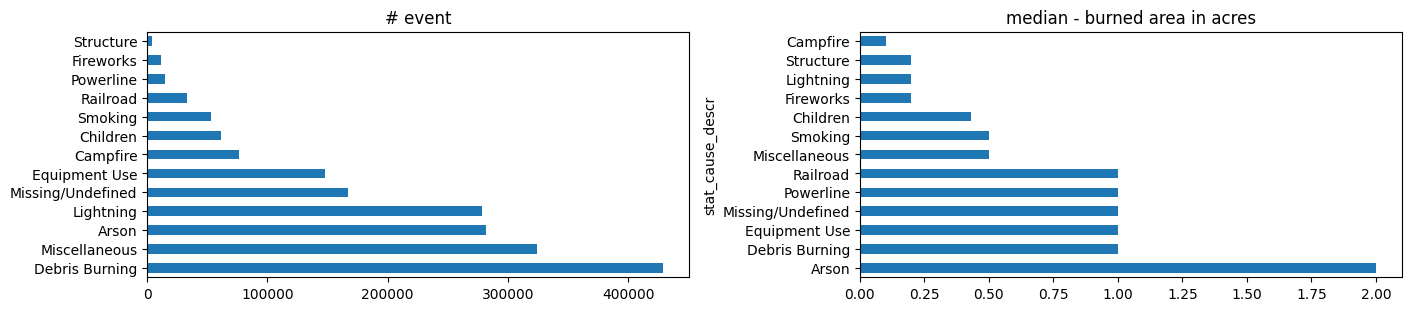

In [6]:
# fire cause area burned
fig,axes = plt.subplots(1,2,figsize = (14,3), layout='constrained')
df['stat_cause_descr'].value_counts().plot(kind='barh', title = '# event',ax = axes[0])
df.groupby('stat_cause_descr')['fire_size'].median().sort_values(ascending=False).plot(kind = 'barh',ax=axes[1],title= 'median - burned area in acres')


#### Mostly fires are casued due to `Debris burning`, but in terms of mean area burned it is quite low in ranking

<AxesSubplot: title={'center': 'max - burned area in acres'}, ylabel='stat_cause_descr'>

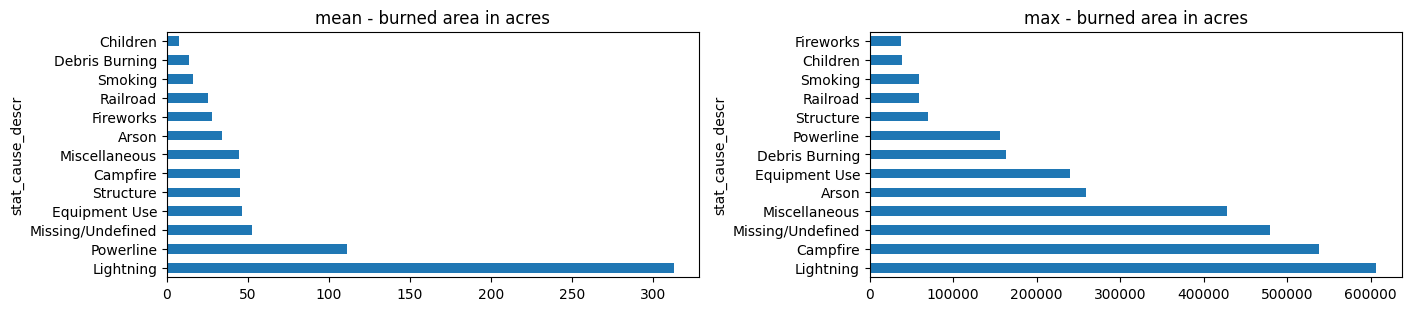

In [7]:
# fire cause area burned
fig,axes = plt.subplots(1,2,figsize = (14,3), layout='constrained')
df.groupby('stat_cause_descr')['fire_size'].mean().sort_values(ascending=False).plot(kind = 'barh',ax=axes[0], title='mean - burned area in acres')
df.groupby('stat_cause_descr')['fire_size'].max().sort_values(ascending=False).plot(kind = 'barh',ax=axes[1], title='max - burned area in acres')

#### `Lightening` is the cause of largest burned area in mean and max terms

<AxesSubplot: xlabel='fire_size', ylabel='stat_cause_descr'>

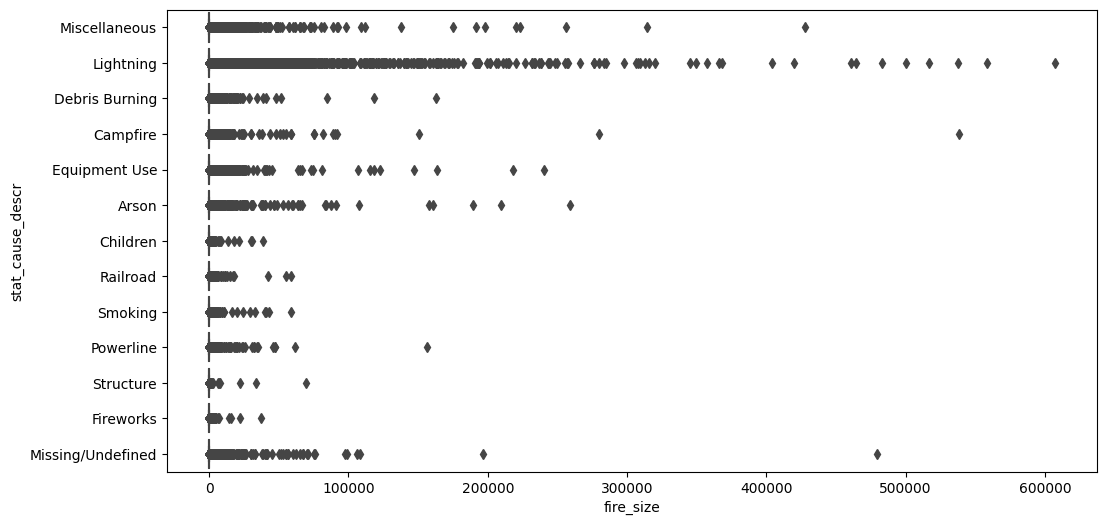

In [8]:
fig, ax=plt.subplots(1,figsize=(12,6))
sns.boxplot(data= df, y='stat_cause_descr', x='fire_size',orient='h')

<AxesSubplot: title={'center': '# events by size class'}>

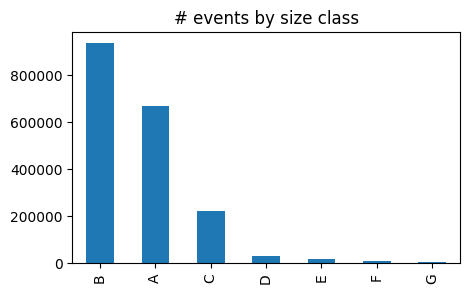

In [9]:
# fire size class distribution
df['fire_size_class'].value_counts().plot(kind='bar', title = '# events by size class', figsize = (5,3))

In [27]:
pd.crosstab(df['stat_cause_descr'], df['fire_size_class'])

fire_size_class,A,B,C,D,E,F,G
stat_cause_descr,,,,,,,
Arson,61919,154181,55913,6239,2276,772,155
Campfire,44215,25911,5002,557,235,133,86
Children,26732,31489,2576,218,100,42,10
Debris Burning,95778,272347,54653,4263,1410,462,115
Equipment Use,53126,73377,16580,2493,1266,571,199
Fireworks,6054,4356,746,176,115,47,6
Lightning,152396,85802,24325,5773,4291,3462,2419
Miscellaneous,134441,152090,29189,4398,2146,1125,416
Missing/Undefined,52868,86781,21269,3012,1662,878,253


<AxesSubplot: >

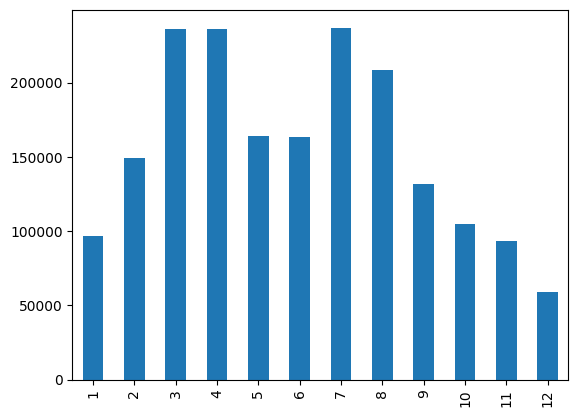

In [11]:
#month based distribution by count
df['month'].value_counts().sort_index().plot(kind='bar')

## Classification

Different classifiers from Scikit learn are explored to test which one works for this specific use-case. Neural network is explored separately at the end

### Based on sample data

As dataset is quite large, initial investigation is done on sample of size. It is set to 20%

In [6]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn import  tree
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

from feature_engine.creation import CyclicalFeatures
from feature_engine.encoding import OrdinalEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV


##### sample data for quick testing

In [29]:
# pct of data to be selected for initial analysis

pct= .2 # 20%

s_indices = np.random.randint(len(df),size = int(pct*len(df)))
df_i = df.iloc[s_indices,:]



### 1. first attempt- base single feature 

initial attempt to just check how simple fire cause classification works with fire size as input feature

In [14]:
# data setup

features = ['fire_size']

target = 'stat_cause_code'
x_train_i, x_test_i, y_train_i, y_test_i = train_test_split(
                        df_i[features],df_i[target],
                        test_size= .2,
                        random_state =2
)

In [15]:
df_i.head()

,discovery_date,fire_size,fire_size_class,lat,lon,fips_code,stat_cause_code,stat_cause_descr,year,month,doy,quarter
772595,2006-08-08,0.25,A,44.6,-119.4,023,1.0,Lightning,2006,8,220,3
401654,2008-02-26,4.00,B,31.0,-86.8,091,7.0,Arson,2008,2,57,1
1514157,2011-03-12,0.20,A,35.3,-81.8,161,13.0,Missing/Undefined,2011,3,71,1
630423,2006-04-02,10.00,C,32.4,-98.1,143,9.0,Miscellaneous,2006,4,92,2
63472,1994-08-05,0.10,A,45.5,-116.4,None,1.0,Lightning,1994,8,217,3


#### Simple base for classification
What if we predict top 2 causes of fires all the time?
- About 40% accuracy will be acheived.

**Attempt is made to systematically find better classification than this base**

In [16]:
# check accuracy for predicting top 2 causes: 5- debris, 9 - miscelleneous
# can this be the base from where to improve?

print(f'train base acc: {y_train_i.isin([5,9]).sum()/len(y_train_i)}')

print(f'test base acc: {y_test_i.isin([5,9]).sum()/len(y_test_i)}')

train base acc: 0.39901088163151355
test base acc: 0.4027041040162725


#### Classifier "Decision Tree": 


In [17]:
clf = DecisionTreeClassifier(max_depth=25, min_samples_split=4)
clf.fit(x_train_i, y_train_i)

print(f" train acc: {clf.score(x_train_i,y_train_i)}")

print(f" test acc: {clf.score(x_test_i,y_test_i)}")

 train acc: 0.2877550070793754
 test acc: 0.2812986080644518


In [18]:
pred_train = clf.predict(x_train_i)

pd.crosstab(y_train_i,pred_train).apply(lambda x: 100*x/x.sum(),axis =1).round(1)

col_0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
stat_cause_code,,,,,,,,,,,,,
1.0,54.8,0.1,0.0,0.0,34.3,0.0,5.9,0.0,4.8,0.0,0.0,0.0,0.1
2.0,27.2,1.3,0.0,0.0,57.1,0.0,7.6,0.0,6.8,0.0,0.0,0.0,0.1
3.0,31.6,0.1,0.7,0.0,54.7,0.0,4.0,0.0,8.8,0.0,0.0,0.0,0.0
4.0,48.9,0.1,0.0,0.6,38.4,0.0,4.0,0.0,8.1,0.0,0.0,0.0,0.0
5.0,14.3,0.1,0.0,0.0,73.5,0.0,7.4,0.0,4.5,0.0,0.0,0.0,0.1
6.0,20.9,0.2,0.0,0.0,65.1,0.6,8.2,0.0,5.0,0.0,0.0,0.0,0.1
7.0,16.6,0.2,0.0,0.0,63.1,0.0,15.2,0.0,4.8,0.0,0.0,0.0,0.1
8.0,31.2,0.1,0.0,0.0,56.5,0.0,2.8,0.3,9.1,0.0,0.0,0.0,0.0
9.0,34.3,0.1,0.0,0.0,51.3,0.0,6.0,0.0,8.1,0.0,0.0,0.0,0.1


#### Classifer "Random Forest": 
    

In [19]:
clf = RandomForestClassifier(max_depth=25, n_estimators=100, min_samples_split = 4)
clf.fit(x_train_i, y_train_i)

print(f" train acc: {clf.score(x_train_i,y_train_i)}")

print(f" test acc: {clf.score(x_test_i,y_test_i)}")

 train acc: 0.28858591968731095
 test acc: 0.2813650806312235


In [20]:
pred_train = clf.predict(x_train_i)

pd.crosstab(y_train_i,pred_train).apply(lambda x: 100*x/x.sum(),axis =1).round(1)

col_0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
stat_cause_code,,,,,,,,,,,,,
1.0,54.5,0.1,0.0,0.0,34.3,0.0,6.1,0.0,4.8,0.0,0.0,0.0,0.1
2.0,27.0,1.0,0.0,0.0,57.1,0.0,7.8,0.0,7.0,0.0,0.0,0.0,0.1
3.0,31.5,0.1,0.6,0.0,54.6,0.0,4.1,0.0,8.9,0.0,0.0,0.0,0.0
4.0,48.8,0.0,0.0,0.5,38.4,0.0,4.1,0.0,8.2,0.0,0.0,0.0,0.0
5.0,14.2,0.1,0.0,0.0,73.4,0.0,7.6,0.0,4.7,0.0,0.0,0.0,0.1
6.0,20.8,0.0,0.0,0.0,64.8,0.7,8.5,0.0,5.1,0.0,0.0,0.0,0.1
7.0,16.4,0.1,0.0,0.0,62.7,0.0,15.7,0.0,5.0,0.0,0.0,0.0,0.1
8.0,31.2,0.1,0.0,0.0,56.3,0.0,2.9,0.4,9.2,0.0,0.0,0.0,0.0
9.0,34.1,0.1,0.0,0.0,51.0,0.0,6.1,0.0,8.6,0.0,0.0,0.0,0.1


#### Classfier -     "AdaBoost":



In [21]:
clf =  AdaBoostClassifier(DecisionTreeClassifier(max_depth=15),learning_rate = 1)
clf.fit(x_train_i, y_train_i)

print(f" train acc: {clf.score(x_train_i,y_train_i)}")

print(f" test acc: {clf.score(x_test_i,y_test_i)}")

 train acc: 0.28861915619162837
 test acc: 0.2810593068240737


In [22]:
pred_train = clf.predict(x_train_i)

pd.crosstab(y_train_i,pred_train).apply(lambda x: 100*x/x.sum(),axis =1).round(1)

col_0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
stat_cause_code,,,,,,,,,,,,,
1.0,54.4,0.1,0.0,0.0,34.3,0.0,6.1,0.0,4.8,0.0,0.0,0.0,0.1
2.0,26.9,1.2,0.0,0.0,57.1,0.0,7.8,0.0,6.9,0.0,0.0,0.0,0.1
3.0,31.4,0.1,0.7,0.0,54.7,0.0,4.1,0.0,8.8,0.0,0.0,0.0,0.0
4.0,48.7,0.1,0.0,0.4,38.5,0.0,4.1,0.0,8.1,0.0,0.0,0.0,0.1
5.0,14.2,0.1,0.0,0.0,73.4,0.0,7.6,0.0,4.6,0.0,0.0,0.0,0.1
6.0,20.6,0.1,0.0,0.0,65.0,0.8,8.4,0.0,5.0,0.0,0.0,0.0,0.1
7.0,16.3,0.1,0.0,0.0,62.9,0.0,15.6,0.0,4.9,0.0,0.0,0.0,0.1
8.0,31.1,0.1,0.0,0.0,56.3,0.0,2.8,0.6,9.1,0.0,0.0,0.0,0.0
9.0,34.1,0.1,0.0,0.0,51.2,0.0,6.1,0.0,8.4,0.0,0.0,0.0,0.1


### Results shows that just using fire size a input feature gives worse performance that initial base of 40%

### 2. second attempt- feature fire_size_class

still using fire size, but as cateogrical feature

In [30]:
# data setup

features = ['fire_size_class']
target = 'stat_cause_code'

# set up the encoder. Conver string based classes to numerical categorical values
encoder = OrdinalEncoder( variables=features)

encoder.fit(df_i,df_i[target])

df_i = encoder.transform(df_i)
df_i.head()

,discovery_date,fire_size,fire_size_class,lat,lon,fips_code,stat_cause_code,stat_cause_descr,year,month,doy,quarter
585898,2004-03-22,3.00,6,34.0,-80.2,061,5.0,Debris Burning,2004,3,82,1
277554,2003-08-19,0.30,6,47.5,-114.1,None,11.0,Powerline,2003,8,231,3
731210,1995-05-24,0.10,3,33.8,-79.1,051,13.0,Missing/Undefined,1995,5,144,2
1491171,2011-01-29,3.27,6,31.4,-83.4,277,5.0,Debris Burning,2011,1,29,1
1765208,2014-10-12,0.01,3,32.8,-94.4,315,5.0,Debris Burning,2014,10,285,4


In [24]:

x_train_i, x_test_i, y_train_i, y_test_i = train_test_split(
                        df_i[features],df_i[target],
                        test_size= .2,
                        random_state =2
)

In [25]:
# check accuracy for predicting top 2 causes: 5- debris, 9 - miscelleneous
# can this be the base from where to improve?

print(f'train base acc: {y_train_i.isin([5,9]).sum()/len(y_train_i)}')

print(f'test base acc: {y_test_i.isin([5,9]).sum()/len(y_test_i)}')

train base acc: 0.39901088163151355
test base acc: 0.4027041040162725


#### Classifier "Decision Tree": 


In [26]:
clf = DecisionTreeClassifier(max_depth=25, min_samples_split=4)
clf.fit(x_train_i, y_train_i)

print(f" train acc: {clf.score(x_train_i,y_train_i)}")

print(f" test acc: {clf.score(x_test_i,y_test_i)}")

 train acc: 0.2647985535473321
 test acc: 0.26779138249644374


In [27]:
pred_train = clf.predict(x_train_i)

pd.crosstab(y_train_i,pred_train).apply(lambda x: 100*x/x.sum(),axis =1).round(1)

col_0,1.0,5.0,7.0
stat_cause_code,,,
1.0,58.6,30.5,10.8
2.0,37.3,49.2,13.5
3.0,43.6,48.6,7.8
4.0,58.3,34.4,7.3
5.0,22.8,63.4,13.8
6.0,29.6,56.2,14.1
7.0,23.3,54.6,22.2
8.0,43.7,51.5,4.8
9.0,42.7,47.0,10.4


#### Classifer "Random Forest": 
    

In [28]:
clf = RandomForestClassifier(max_depth=25, n_estimators=100, min_samples_split = 4)
clf.fit(x_train_i, y_train_i)

print(f" train acc: {clf.score(x_train_i,y_train_i)}")

print(f" test acc: {clf.score(x_test_i,y_test_i)}")

 train acc: 0.2647985535473321
 test acc: 0.26779138249644374


In [29]:
pred_train = clf.predict(x_train_i)

pd.crosstab(y_train_i,pred_train).apply(lambda x: 100*x/x.sum(),axis =1).round(1)

col_0,1.0,5.0,7.0
stat_cause_code,,,
1.0,58.6,30.5,10.8
2.0,37.3,49.2,13.5
3.0,43.6,48.6,7.8
4.0,58.3,34.4,7.3
5.0,22.8,63.4,13.8
6.0,29.6,56.2,14.1
7.0,23.3,54.6,22.2
8.0,43.7,51.5,4.8
9.0,42.7,47.0,10.4


#### Classfier -     "AdaBoost":



In [30]:
clf =  AdaBoostClassifier(DecisionTreeClassifier(max_depth=15),learning_rate = 1)
clf.fit(x_train_i, y_train_i)

print(f" train acc: {clf.score(x_train_i,y_train_i)}")

print(f" test acc: {clf.score(x_test_i,y_test_i)}")

 train acc: 0.2647985535473321
 test acc: 0.26779138249644374


In [31]:
pred_train = clf.predict(x_train_i)

pd.crosstab(y_train_i,pred_train).apply(lambda x: 100*x/x.sum(),axis =1).round(1)

col_0,1.0,5.0,7.0
stat_cause_code,,,
1.0,58.6,30.5,10.8
2.0,37.3,49.2,13.5
3.0,43.6,48.6,7.8
4.0,58.3,34.4,7.3
5.0,22.8,63.4,13.8
6.0,29.6,56.2,14.1
7.0,23.3,54.6,22.2
8.0,43.7,51.5,4.8
9.0,42.7,47.0,10.4


##### Result: 
fire_size_class gives slightly worse performance than fire_size

### 3. second attempt- add all features
We add all features now in the classification included created features for date that can be used in the model

- AdaBoost was dropped as in general it did not show better perfomance than Decisiontree or RandomForest and was much slower

In [32]:
# data setup

features = ['fire_size_class','fire_size','lat','lon','year','month','doy','quarter']
target = 'stat_cause_code'

# set up the encoder. if executed in sequence fire_size_class is already encoded
# encoder = OrdinalEncoder( variables=features)

# encoder.fit(df_i,df_i[target])

# df_i = encoder.transform(df_i)

# scale fire size


df_i.head()

,discovery_date,fire_size,fire_size_class,lat,lon,fips_code,stat_cause_code,stat_cause_descr,year,month,doy,quarter
772595,2006-08-08,0.25,2,44.6,-119.4,023,1.0,Lightning,2006,8,220,3
401654,2008-02-26,4.00,6,31.0,-86.8,091,7.0,Arson,2008,2,57,1
1514157,2011-03-12,0.20,2,35.3,-81.8,161,13.0,Missing/Undefined,2011,3,71,1
630423,2006-04-02,10.00,5,32.4,-98.1,143,9.0,Miscellaneous,2006,4,92,2
63472,1994-08-05,0.10,2,45.5,-116.4,None,1.0,Lightning,1994,8,217,3


In [33]:

x_train_i, x_test_i, y_train_i, y_test_i = train_test_split(
                        df_i[features],df_i[target],
                        test_size= .2,
                        random_state =2
)

In [34]:
# check accuracy for predicting top 2 causes: 5- debris, 9 - miscelleneous
# can this be the base from where to improve?

print(f'train base acc: {y_train_i.isin([5,9]).sum()/len(y_train_i)}')

print(f'test base acc: {y_test_i.isin([5,9]).sum()/len(y_test_i)}')

train base acc: 0.39901088163151355
test base acc: 0.4027041040162725


In [35]:

classifiers = {
    "Decision Tree": DecisionTreeClassifier(max_depth=25),
    "Random Forest": RandomForestClassifier(max_depth=25, n_estimators=100, min_samples_split = 4),
    # "AdaBoost": AdaBoostClassifier(n_estimators=100)
}


In [36]:

train_result = {
    'train': [],
    'test':[],
    'dur':[],

}
index = []

models = {}

for clf_name, clf in classifiers.items():
    start = time.perf_counter()
    print(f'Training for classifer type: {clf_name}')
    clf.fit(x_train_i,y_train_i)
    
    models[clf_name] = clf
    train_result['train'].append(clf.score(x_train_i,y_train_i))
    train_result['test'].append(clf.score(x_test_i,y_test_i))
    train_result['dur'].append(time.perf_counter() -start)
    index.append(clf_name)


df_result = pd.DataFrame(train_result,index=index)
df_result


Training for classifer type: Decision Tree
Training for classifer type: Random Forest


,train,test,dur
Decision Tree,0.899220,0.526516,3.356281
Random Forest,0.940799,0.590130,84.317858


In [38]:
# which paramters does Random Forest prefer?

for clf_name, clf in models.items():
    sel = SelectFromModel(clf)  

    print(f' features preferred by model {clf_name}')
    print(f'\t {x_train_i.columns[sel.get_support()]}')
    

 features preferred by model Decision Tree
	 Index(['lat', 'lon', 'year', 'doy'], dtype='object')
 features preferred by model Random Forest
	 Index(['lat', 'lon', 'year', 'doy'], dtype='object')


##### Result:
results are much better with multiple features as default without extra preprocessing. interestingly `fire size` or `fire size class` are not in the list. 

### 4. second attempt- add all features - transform time features

In this case we try to process doy, month, quarter features in a way to encode their cyclic nature. Will it impact RandomForest clssifier performance?

We are still keeping lon, as original values, as normalization of those features will be used for Neural net classifier

In [32]:
# data setup

features = ['fire_size_class', 'fire_size','lat','lon','year','month','doy','quarter']
target = 'stat_cause_code'

# set up the encoder. if executed in sequence fire_size_class is already encoded
# encoder = OrdinalEncoder( variables=features)

# encoder.fit(df_i,df_i[target])

# df_i = encoder.transform(df_i)

# scale fire size


df_i.head()

,discovery_date,fire_size,fire_size_class,lat,lon,fips_code,stat_cause_code,stat_cause_descr,year,month,doy,quarter
585898,2004-03-22,3.00,6,34.0,-80.2,061,5.0,Debris Burning,2004,3,82,1
277554,2003-08-19,0.30,6,47.5,-114.1,None,11.0,Powerline,2003,8,231,3
731210,1995-05-24,0.10,3,33.8,-79.1,051,13.0,Missing/Undefined,1995,5,144,2
1491171,2011-01-29,3.27,6,31.4,-83.4,277,5.0,Debris Burning,2011,1,29,1
1765208,2014-10-12,0.01,3,32.8,-94.4,315,5.0,Debris Burning,2014,10,285,4


In [33]:
# Create time features for quarter, month and doy whcih has cyclic features

cyclical = CyclicalFeatures(variables=['quarter','month', 'doy'], drop_original=False)

X = cyclical.fit_transform(df_i[features])
X.head()

,fire_size_class,fire_size,lat,lon,year,month,doy,quarter,quarter_sin,quarter_cos,month_sin,month_cos,doy_sin,doy_cos
585898,6,3.00,34.0,-80.2,2004,3,82,1,1.000000e+00,6.123234e-17,1.000000,6.123234e-17,0.986731,0.162366
277554,6,0.30,47.5,-114.1,2003,8,231,3,-1.000000e+00,-1.836970e-16,-0.866025,-5.000000e-01,-0.733885,-0.679273
731210,3,0.10,33.8,-79.1,1995,5,144,2,1.224647e-16,-1.000000e+00,0.500000,-8.660254e-01,0.620609,-0.784120
1491171,6,3.27,31.4,-83.4,2011,1,29,1,1.000000e+00,6.123234e-17,0.500000,8.660254e-01,0.477536,0.878612
1765208,3,0.01,32.8,-94.4,2014,10,285,4,-2.449294e-16,1.000000e+00,-0.866025,5.000000e-01,-0.983798,0.179281


In [41]:

x_train_i, x_test_i, y_train_i, y_test_i = train_test_split(
                        X,df_i[target],
                        test_size= .2,
                        random_state =2
)

In [42]:
# check accuracy for predicting top 2 causes: 5- debris, 9 - miscelleneous
# can this be the base from where to improve?

print(f'train base acc: {y_train_i.isin([5,9]).sum()/len(y_train_i)}')

print(f'test base acc: {y_test_i.isin([5,9]).sum()/len(y_test_i)}')

train base acc: 0.39901088163151355
test base acc: 0.4027041040162725


In [43]:

classifiers = {
    "Decision Tree": DecisionTreeClassifier(max_depth=25),
    "Random Forest": RandomForestClassifier(max_depth=25, n_estimators=100, min_samples_split = 4),
    # "AdaBoost": AdaBoostClassifier(n_estimators=100)
}


In [44]:

train_result = {
    'train': [],
    'test':[],
    'dur':[],

}
index = []

models = {}

for clf_name, clf in classifiers.items():
    start = time.perf_counter()
    print(f'Training for classifer type: {clf_name}')
    clf.fit(x_train_i,y_train_i)
    
    models[clf_name] = clf
    
    train_result['train'].append(clf.score(x_train_i,y_train_i))
    train_result['test'].append(clf.score(x_test_i,y_test_i))
    train_result['dur'].append(time.perf_counter() -start)
    index.append(clf_name)


df_result = pd.DataFrame(train_result,index=index)
df_result


Training for classifer type: Decision Tree
Training for classifer type: Random Forest


,train,test,dur
Decision Tree,0.899519,0.523764,4.808941
Random Forest,0.941457,0.570973,94.877818


In [45]:
# which paramters does Random Forest prefer?

for clf_name, clf in models.items():
    sel = SelectFromModel(clf)  

    print(f' features preferred by model {clf_name}')
    print(f'\t {x_train_i.columns[sel.get_support()]}')
    

 features preferred by model Decision Tree
	 Index(['fire_size', 'lat', 'lon', 'year', 'doy_sin', 'doy_cos'], dtype='object')
 features preferred by model Random Forest
	 Index(['fire_size', 'lat', 'lon', 'year', 'doy', 'doy_sin', 'doy_cos'], dtype='object')


##### Result:
- RandomForest performance has decreased a little with more features. 
- However, This time fire size is selected. 
- month and quarter does not seems to be that import or they are redundant in the presence of doy

### 5 attempt- add all features - transform time features with gridsearch for hyperparams

- We try to execute a Grid Search if any hyperparams make better performance for these classifiers with these features. 
- Also BaggingClassifier is added in the list, which is an ensemble on DecisionTree

In [35]:
# data setup

features = ['fire_size_class', 'fire_size','lat','lon','year','month','doy','quarter']
target = 'stat_cause_code'

# set up the encoder. if executed in sequence fire_size_class is already encoded
# encoder = OrdinalEncoder( variables=features)

# encoder.fit(df_i,df_i[target])

# df_i = encoder.transform(df_i)

# scale fire size


df_i.head()

,discovery_date,fire_size,fire_size_class,lat,lon,fips_code,stat_cause_code,stat_cause_descr,year,month,doy,quarter
585898,2004-03-22,3.00,6,34.0,-80.2,061,5.0,Debris Burning,2004,3,82,1
277554,2003-08-19,0.30,6,47.5,-114.1,None,11.0,Powerline,2003,8,231,3
731210,1995-05-24,0.10,3,33.8,-79.1,051,13.0,Missing/Undefined,1995,5,144,2
1491171,2011-01-29,3.27,6,31.4,-83.4,277,5.0,Debris Burning,2011,1,29,1
1765208,2014-10-12,0.01,3,32.8,-94.4,315,5.0,Debris Burning,2014,10,285,4


In [37]:
# Create time features for month and doy whcih has cyclic features

cyclical = CyclicalFeatures(variables=['quarter','month', 'doy'], drop_original=False)

X = cyclical.fit_transform(df_i[features])
X.head()

,fire_size_class,fire_size,lat,lon,year,month,doy,quarter,quarter_sin,quarter_cos,month_sin,month_cos,doy_sin,doy_cos
585898,6,3.00,34.0,-80.2,2004,3,82,1,1.000000e+00,6.123234e-17,1.000000,6.123234e-17,0.986731,0.162366
277554,6,0.30,47.5,-114.1,2003,8,231,3,-1.000000e+00,-1.836970e-16,-0.866025,-5.000000e-01,-0.733885,-0.679273
731210,3,0.10,33.8,-79.1,1995,5,144,2,1.224647e-16,-1.000000e+00,0.500000,-8.660254e-01,0.620609,-0.784120
1491171,6,3.27,31.4,-83.4,2011,1,29,1,1.000000e+00,6.123234e-17,0.500000,8.660254e-01,0.477536,0.878612
1765208,3,0.01,32.8,-94.4,2014,10,285,4,-2.449294e-16,1.000000e+00,-0.866025,5.000000e-01,-0.983798,0.179281


In [38]:

x_train_i, x_test_i, y_train_i, y_test_i = train_test_split(
                        X,df_i[target],
                        test_size= .2,
                        random_state =2
)

In [50]:
# check accuracy for predicting top 2 causes: 5- debris, 9 - miscelleneous
# can this be the base from where to improve?

print(f'train base acc: {y_train_i.isin([5,9]).sum()/len(y_train_i)}')

print(f'test base acc: {y_test_i.isin([5,9]).sum()/len(y_test_i)}')

train base acc: 0.39901088163151355
test base acc: 0.4027041040162725


In [39]:
# Set base classifiers and hyperparam grids for each classifier
classifiers = {
    "Decision Tree": DecisionTreeClassifier(random_state= 3),
    "Random Forest": RandomForestClassifier(random_state=3),
    "Bagging Classifier": BaggingClassifier(random_state=3)
    # "AdaBoost": AdaBoostClassifier(n_estimators=100)
}

class_params ={

    "Decision Tree":{ 
                 'min_samples_split': [2,3,4],
                'max_features': [ 'sqrt', 'log2'],
                'max_depth' : [5,10,15,20,25],
                'criterion' :['gini', 'entropy','log_loss']
            },
    "Random Forest":{ 
                'n_estimators': [50,100],
                'min_samples_split': [4],
                # 'max_features': [ 'sqrt', 'log2'],
                'max_depth' : [25],
                'criterion' :['gini', 'log_loss']
            } ,
    "Bagging Classifier":{
                'n_estimators': [ 50, 100],
                'base_estimator': [None,
                        DecisionTreeClassifier(max_depth=25, criterion='log_loss'),
                        DecisionTreeClassifier(max_depth=25, min_samples_split=4, criterion='log_loss')
                        ]
                # 'min_samples_split': [4],
                # 'max_features': [ 'sqrt', 'log2'],
                # 'max_depth' : [25],
                # 'oob_score' :[True,False]

    }
}

In [58]:

clf_name = 'Decision Tree'

start = time.perf_counter()
clf = GridSearchCV(estimator=classifiers[clf_name],param_grid=class_params[clf_name],cv=5,n_jobs =4)
print(f'Training for classifer type: {clf_name}')
clf.fit(x_train_i,y_train_i)


print(f'train set score: {clf.best_estimator_.score(x_train_i,y_train_i)}')
print(f'train set score: {clf.best_estimator_.score(x_test_i,y_test_i)}')
print(f'training time : {time.perf_counter() -start} ')




Training for classifer type: Decision Tree
train set score: 0.940852316916716
train set score: 0.46177162684959916
training time : 97.59240275609773 


In [60]:
pd.DataFrame(clf.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_features,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
87,1.165234,0.059286,0.043877,0.001989,log_loss,25,log2,2,"{'criterion': 'log_loss', 'max_depth': 25, 'ma...",0.437457,0.438571,0.447777,0.447811,0.448549,0.444033,0.004935,1
84,1.178387,0.037700,0.042814,0.002339,log_loss,25,sqrt,2,"{'criterion': 'log_loss', 'max_depth': 25, 'ma...",0.437457,0.438571,0.447777,0.447811,0.448549,0.444033,0.004935,1
57,1.156275,0.020916,0.047206,0.004650,entropy,25,log2,2,"{'criterion': 'entropy', 'max_depth': 25, 'max...",0.437457,0.438571,0.447777,0.447811,0.448549,0.444033,0.004935,1
54,1.161968,0.037976,0.045365,0.001214,entropy,25,sqrt,2,"{'criterion': 'entropy', 'max_depth': 25, 'max...",0.437457,0.438571,0.447777,0.447811,0.448549,0.444033,0.004935,1
78,1.061514,0.037640,0.036178,0.002924,log_loss,20,sqrt,2,"{'criterion': 'log_loss', 'max_depth': 20, 'ma...",0.435580,0.436294,0.440914,0.448625,0.433842,0.439051,0.005328,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,0.439845,0.019460,0.012517,0.000946,gini,5,log2,3,"{'criterion': 'gini', 'max_depth': 5, 'max_fea...",0.346606,0.350810,0.351791,0.346938,0.349968,0.349223,0.002085,85
3,0.527810,0.024044,0.014117,0.002104,gini,5,log2,2,"{'criterion': 'gini', 'max_depth': 5, 'max_fea...",0.346606,0.350810,0.351791,0.346938,0.349968,0.349223,0.002085,85
2,0.480450,0.024246,0.012774,0.001397,gini,5,sqrt,4,"{'criterion': 'gini', 'max_depth': 5, 'max_fea...",0.346606,0.350810,0.351791,0.346938,0.349968,0.349223,0.002085,85
1,0.490967,0.036238,0.013943,0.000681,gini,5,sqrt,3,"{'criterion': 'gini', 'max_depth': 5, 'max_fea...",0.346606,0.350810,0.351791,0.346938,0.349968,0.349223,0.002085,85


In [ ]:
# which paramters does Decision Tree prefer?

sel = SelectFromModel(clf.best_estimator_)  

print(f' features preferred by model {clf_name}')
print(f'\t {x_train_i.columns[sel.get_support()]}')


 features preferred by model Decision Tree
	 Index(['fire_size', 'lat', 'lon', 'year', 'doy_sin', 'doy_cos'], dtype='object')


In [ ]:

clf_name = 'Random Forest'

start = time.perf_counter()
clf = GridSearchCV(estimator=classifiers[clf_name],param_grid=class_params[clf_name],cv=5,n_jobs =4)
print(f'Training for classifer type: {clf_name}')
clf.fit(x_train_i,y_train_i)
print(f'training time : {time.perf_counter() -start} ')




Training for classifer type: Random Forest
training time : 411.2210373500129 


In [ ]:
pd.DataFrame(clf.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,35.133479,0.373267,2.001958,0.145644,gini,25,4,50,"{'criterion': 'gini', 'max_depth': 25, 'min_sa...",0.546755,0.549531,0.550777,0.546789,0.548160,0.548402,0.001568,4
1,70.656325,0.864719,3.674793,0.069598,gini,25,4,100,"{'criterion': 'gini', 'max_depth': 25, 'min_sa...",0.550361,0.551840,0.553619,0.551109,0.552897,0.551965,0.001177,2
2,40.540862,0.205265,2.000707,0.184184,log_loss,25,4,50,"{'criterion': 'log_loss', 'max_depth': 25, 'mi...",0.550877,0.552688,0.550710,0.551608,0.553212,0.551819,0.000986,3
3,76.571445,7.770619,3.306985,0.429428,log_loss,25,4,100,"{'criterion': 'log_loss', 'max_depth': 25, 'mi...",0.554450,0.556427,0.556660,0.554931,0.556968,0.555887,0.001004,1


In [ ]:

print(f'train set score: {clf.best_estimator_.score(x_train_i,y_train_i)}')
print(f'train set score: {clf.best_estimator_.score(x_test_i,y_test_i)}')




train set score: 0.9662782427195438
train set score: 0.5733524774325636


In [ ]:
# which paramters does Decision Tree prefer?

sel = SelectFromModel(clf.best_estimator_)  

print(f' features preferred by model {clf_name}')
print(f'\t {x_train_i.columns[sel.get_support()]}')


 features preferred by model Random Forest
	 Index(['fire_size', 'lat', 'lon', 'year', 'doy', 'doy_sin', 'doy_cos'], dtype='object')


In [62]:

clf_name = 'Bagging Classifier'

start = time.perf_counter()
clf = GridSearchCV(estimator=classifiers[clf_name],param_grid=class_params[clf_name],cv=5,n_jobs =4)
print(f'Training for classifer type: {clf_name}')
clf.fit(x_train_i,y_train_i)
print(f'training time : {time.perf_counter() -start} ')




Training for classifer type: Bagging Classifier


/home/vscode/.local/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


training time : 1981.9915928730043 


In [65]:
pd.DataFrame(clf.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_base_estimator,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,265.652672,12.114922,2.480507,0.175765,"DecisionTreeClassifier(criterion='log_loss', m...",100,{'base_estimator': DecisionTreeClassifier(crit...,0.591275,0.596012,0.592937,0.595580,0.595423,0.594245,0.001834,1
3,283.462633,8.361209,3.330220,0.205573,"DecisionTreeClassifier(criterion='log_loss', m...",100,{'base_estimator': DecisionTreeClassifier(crit...,0.587852,0.593818,0.590710,0.594034,0.593645,0.592012,0.002409,2
4,139.050290,3.001376,1.522362,0.171501,"DecisionTreeClassifier(criterion='log_loss', m...",50,{'base_estimator': DecisionTreeClassifier(crit...,0.588317,0.592339,0.590694,0.592140,0.592100,0.591118,0.001518,3
2,146.721541,4.016175,1.795739,0.045397,"DecisionTreeClassifier(criterion='log_loss', m...",50,{'base_estimator': DecisionTreeClassifier(crit...,0.586190,0.591924,0.588400,0.590478,0.591418,0.589682,0.002122,4
1,275.696688,5.388113,3.996509,0.346528,None,100,"{'base_estimator': None, 'n_estimators': 100}",0.585708,0.591375,0.587819,0.591924,0.589989,0.589363,0.002312,5
0,140.095669,0.794125,2.061592,0.129688,None,50,"{'base_estimator': None, 'n_estimators': 50}",0.583099,0.589281,0.584944,0.589896,0.588543,0.587153,0.002657,6


In [67]:
clf.best_estimator_.get_params()

{'base_estimator__ccp_alpha': 0.0,
 'base_estimator__class_weight': None,
 'base_estimator__criterion': 'log_loss',
 'base_estimator__max_depth': 25,
 'base_estimator__max_features': None,
 'base_estimator__max_leaf_nodes': None,
 'base_estimator__min_impurity_decrease': 0.0,
 'base_estimator__min_samples_leaf': 1,
 'base_estimator__min_samples_split': 4,
 'base_estimator__min_weight_fraction_leaf': 0.0,
 'base_estimator__random_state': None,
 'base_estimator__splitter': 'best',
 'base_estimator': DecisionTreeClassifier(criterion='log_loss', max_depth=25, min_samples_split=4),
 'bootstrap': True,
 'bootstrap_features': False,
 'max_features': 1.0,
 'max_samples': 1.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 3,
 'verbose': 0,
 'warm_start': False}

In [64]:

print(f'train set score: {clf.best_estimator_.score(x_train_i,y_train_i)}')
print(f'train set score: {clf.best_estimator_.score(x_test_i,y_test_i)}')




train set score: 0.9700539096100028
train set score: 0.6086494103883328


##### Result:
- RandomForest performance has decreased a little with more features. This time fire size is selected. month and quarter does not seems to be that important or they are redundant in the presence of doy.
- Bagging Classifer seems to outperform (60% accuracy, highest so far) RandomForest by a small margin. Can itjust be about some further tuning?

### 7 attempt- Neural network -  with gridsearch for hyperparams
- Attempt to use classic backprop Neural network classifer from sklearn 
- features are further processed to be normalized other than categorical features
- also full dataset is used

In [68]:

from sklearn.neural_network import MLPClassifier

from feature_engine.wrappers import SklearnTransformerWrapper

In [77]:
# data setup

features = ['fire_size_class', 'fire_size','lat','lon','month','doy','quarter']
target = 'stat_cause_code'

# # set up the encoder. if executed in sequence fire_size_class is already encoded
encoder = OrdinalEncoder( variables='fire_size_class')

encoder.fit(df,df[target])

df_i = encoder.transform(df)

# scale fire size


df_i.head()

,discovery_date,fire_size,fire_size_class,lat,lon,fips_code,stat_cause_code,stat_cause_descr,year,month,doy,quarter
0,2005-02-02,0.10,3,40.0,-121.0,063,9.0,Miscellaneous,2005,2,33,1
1,2004-05-12,0.25,3,38.9,-120.4,061,1.0,Lightning,2004,5,133,2
2,2004-05-31,0.10,3,39.0,-120.7,017,5.0,Debris Burning,2004,5,152,2
3,2004-06-28,0.10,3,38.6,-119.9,003,1.0,Lightning,2004,6,180,2
4,2004-06-28,0.10,3,38.6,-119.9,003,1.0,Lightning,2004,6,180,2


In [101]:
# Create time features for month and doy whcih has cyclic features

cyclical = CyclicalFeatures(variables=['quarter','month', 'doy'], drop_original=True)

X = cyclical.fit_transform(df_i[features])
X.head()

,fire_size_class,fire_size,lat,lon,quarter_sin,quarter_cos,month_sin,month_cos,doy_sin,doy_cos
0,3,0.10,40.0,-121.0,1.000000e+00,6.123234e-17,8.660254e-01,0.500000,0.536696,0.843776
1,3,0.25,38.9,-120.4,1.224647e-16,-1.000000e+00,5.000000e-01,-0.866025,0.756771,-0.653680
2,3,0.10,39.0,-120.7,1.224647e-16,-1.000000e+00,5.000000e-01,-0.866025,0.507415,-0.861702
3,3,0.10,38.6,-119.9,1.224647e-16,-1.000000e+00,1.224647e-16,-1.000000,0.051479,-0.998674
4,3,0.10,38.6,-119.9,1.224647e-16,-1.000000e+00,1.224647e-16,-1.000000,0.051479,-0.998674


In [102]:
# set up the wrapper with the StandardScaler to scale fire_size,lat and lon
scaler = SklearnTransformerWrapper(transformer = StandardScaler(),
                                    variables = ['fire_size', 'lon', 'lat'])

# fit the wrapper + StandardScaler
X= scaler.fit_transform(X)

In [103]:

x_train_i, x_test_i, y_train_i, y_test_i = train_test_split(
                        X,df_i[target],
                        test_size= .2,
                        random_state =2
)

In [104]:
x_train_i.head()

,fire_size_class,fire_size,lat,lon,quarter_sin,quarter_cos,month_sin,month_cos,doy_sin,doy_cos
1656774,3,-0.029797,1.778575,-1.297749,-1.0,-1.836970e-16,-1.000000,-1.836970e-16,-0.905702,-0.423914
1820632,6,-0.029436,0.393995,-0.053520,1.0,6.123234e-17,1.000000,6.123234e-17,0.905702,0.423914
385689,6,-0.029036,-0.224994,0.113972,1.0,6.123234e-17,1.000000,6.123234e-17,0.999079,0.042905
699044,5,-0.022630,-0.941718,0.383156,1.0,6.123234e-17,0.866025,5.000000e-01,0.710135,0.704066
1729261,6,-0.029436,-0.273861,-1.088384,-1.0,-1.836970e-16,-0.500000,-8.660254e-01,-0.187719,-0.982223


In [82]:
# check accuracy for predicting top 2 causes: 5- debris, 9 - miscelleneous
# can this be the base from where to improve?

print(f'train base acc: {y_train_i.isin([5,9]).sum()/len(y_train_i)}')

print(f'test base acc: {y_test_i.isin([5,9]).sum()/len(y_test_i)}')

train base acc: 0.40065422648121607
test base acc: 0.3991034132515096


#### Neural net hyper parameter selection

- Multiple attempts were made with 1,2,3 hidden layer neworks
- none of those hyper params increased performance more than 45% for Neural network.
- One trouble is that it takes long time to train the model to get the results.

In [105]:

params ={ 
        'hidden_layer_sizes': [(50,150,50)],
        # 'activation': [ 'relu', 'tanh'],
        'max_iter' :[1000],
        'alpha' : [.1],
        # 'early_stopping': [False] 
            }

In [106]:

b_clf = MLPClassifier(random_state=2, activation='relu')
start = time.perf_counter()

clf = GridSearchCV(estimator=b_clf,param_grid=params,cv=5,n_jobs =4)

clf.fit(x_train_i,y_train_i)

print(f'Train score: {clf.best_estimator_.score(x_train_i,y_train_i)}')
print(f'test score:{clf.best_estimator_.score(x_test_i,y_test_i)}')
print(f'trained in: {time.perf_counter() -start}')



Train score: 0.449323704509257
test score:0.4485326767581423
trained in: 11407.864200818003


In [98]:
pd.DataFrame(clf.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_hidden_layer_sizes,param_max_iter,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,3762.550078,805.779258,1.340064,0.152472,0.01,"(100, 100, 50)",1000,"{'alpha': 0.01, 'hidden_layer_sizes': (100, 10...",0.448459,0.453361,0.455988,0.458983,0.455739,0.454506,0.003511,1


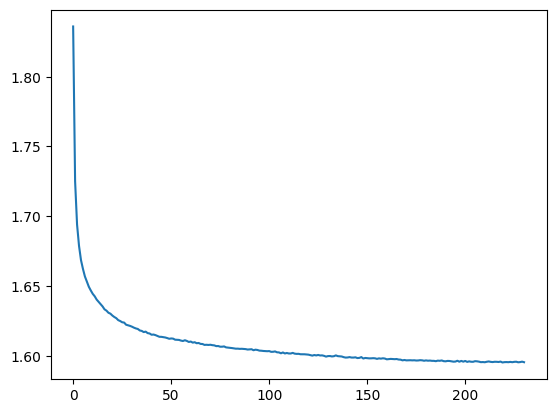

In [99]:
plt.plot(clf.best_estimator_.loss_curve_)

##### Result:
RandomForest performance has decreased a little with more features. This time fire size is selected. month and quarter does not seems to be that import or they are redundant in the presence of doy